In [23]:
import os
from posixpath import join
import paramiko
from scp import SCPClient
import subprocess

run_id = 0
jar_name = 'letter-frequency-1.0-SNAPSHOT.jar'
# connect with ssh


First analyze the letter frequencies in books across the eras. As performance is not relevant now, the job will be executed with 1 reducer, using combiner.
We hypotize that the input files are already in the input folder in hdfs, in /user/hadoop/letter_analysis/input/.

In [24]:
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.1.1.124', username='hadoop', password='ubuntu')
root_dir = '/user/hadoop/historical_analysis'

# run the job for each file
for txt_file in os.listdir('../resources/historical_analysis/input'):
    print(f'Processing {txt_file}')
    input_dir = join(root_dir, 'input', txt_file)
    output_dir = join(root_dir, f'output_{run_id}', txt_file.split('.')[0])
    stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp {input_dir} {output_dir}/count {output_dir}/freq 1 inmappercombiner')
    print(stderr.read().decode('utf-8'))
    print(stdout.read().decode('utf-8'))

# copy the output to local
stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal /user/hadoop/historical_analysis/output_{run_id} .')
print(stderr.read().decode('utf-8'))

if not os.path.exists(f'../resources/historical_analysis/output_{run_id}'):
    os.mkdir(f'../resources/historical_analysis/output_{run_id}')
    
scp = SCPClient(ssh.get_transport())
scp.get(f'output_{run_id}', '../resources/historical_analysis/', recursive=True)
scp.close()
ssh.close()

Processing 1294.txt
2024-06-18 14:39:38,128 INFO client.RMProxy: Connecting to ResourceManager at hadoop-namenode/10.1.1.124:8032
2024-06-18 14:39:38,610 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/hadoop/.staging/job_1716534983775_0236
2024-06-18 14:39:38,719 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-18 14:39:38,926 INFO input.FileInputFormat: Total input files to process : 1
2024-06-18 14:39:38,968 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-18 14:39:39,020 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-18 14:39:39,037 INFO mapreduce.JobSubmitter: number of splits:1
2024-06-18 14:39:39,156 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = fals

After that we can analyze the output files.

../resources/historical_analysis/output_24
             a         c        d         e         f         g         h  \
1294  0.181374  0.000048  0.00359  0.247815  0.000029  0.000134  0.000067   

             i         k         l         m         n         o         r  \
1294  0.128976  0.000278  0.018465  0.000651  0.024084  0.129263  0.008002   

             s         t         u         x         y  
1294  0.003331  0.000641  0.006787  0.000163  0.000967  


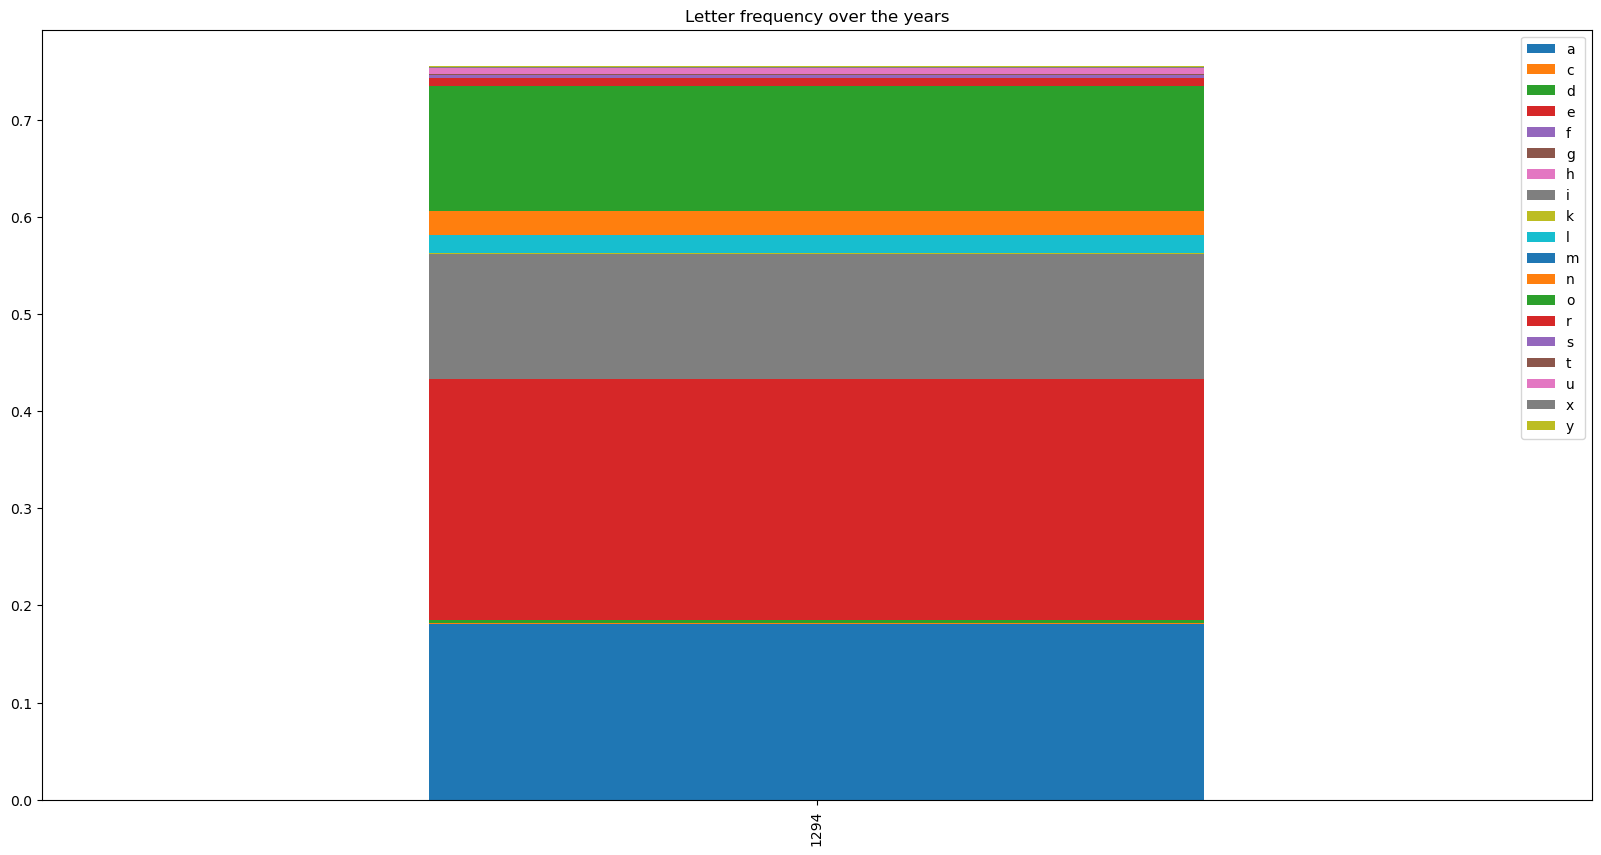

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

run_id = 0

directory = f'../resources/historical_analysis/output_{run_id}'
print(directory)

years = []
for filename in os.listdir(directory):
    year = filename.split('.')[0]
    years.append(year)

df = pd.DataFrame(index=years, columns=[])

for year in years:
    freq_per_year = []
    filepath = f'{directory}/{year}/freq/part-r-00000'
    with open(filepath, 'r') as f:
        for line in f:
            letter, freq = line.strip().split('\t')
            freq = float(freq)
            df.loc[year, letter] = freq
print(df)

df.plot( kind='bar', stacked=True, title='Letter frequency over the years', figsize=(20, 10))